In [1]:
#pip install keras

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tensorflow import keras
from keras.layers import Input,Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from glob import glob
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
import cv2 as cv
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import random
import math

In [3]:
df = pd.read_csv("../input/screw-dataset/train.csv")

In [4]:
df.head()

,filename,anomaly
0,manipulated_front000.png,1
1,manipulated_front001.png,1
2,manipulated_front002.png,1
3,manipulated_front003.png,1
4,manipulated_front004.png,1


In [5]:
train_path = "../input/screw-dataset/train"
test_path = "../input/screw-dataset/test"

In [6]:
len(df[df["anomaly"]==1])

50

In [7]:
folder = glob(train_path+"/*")

In [8]:
IMG_SIZE = (256,256)

In [9]:
def rotate_img(img):
    theta = random.randint(1,359)
    img1 = img.rotate(theta)
    img1 = normalize(img1)
    return img1

def adjust(img, alpha=1.0, beta=0.0):
    dst = alpha * img + beta
    return np.clip(dst, 0.0, 255.0)

def resize_img(img):
    return cv.resize(img,IMG_SIZE)

def normalize(img):
    img = np.asarray(img)
    img = adjust(img,1.3,40)
    return img / 255.0

def image_preprocess(img_path):
    img = cv.imread(img_path)
    img = resize_img(img) 
    img = Image.fromarray(img)
    return img

In [10]:
folder[0][29:31]

'ok'

In [11]:
from keras.utils import np_utils

In [12]:
X = []
y = []
for img_path in folder:
    img = image_preprocess(img_path)
    res = 1
    n = 9
    if(img_path[29:31]=='ok'):
        res = 0
        n = 1
    for j in range(n):
        img1 = rotate_img(img)
        X.append(img1)
        y.append(res)
    img = normalize(img)
    X.append(img)
    y.append(res)
            

In [13]:
folders1 = glob(test_path+"/*")

In [14]:
A = []
tags = []
for i in range(180):
    path = folders1[0][:33]+str(i)+".png"
    img = image_preprocess(path)
    img = normalize(img)
    A.append(img)
    tags.append(path[28:])
    

In [15]:
len(folders1)

180

In [16]:
folders1[0][28:]

'test_12.png'

In [17]:
X1 = np.asarray(X,dtype = 'float32')
y1 = np.asarray(y,dtype = 'float32')

In [18]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X1,y1)

3

In [19]:
for train_index, test_index in skf.split(X1,y1):
    X_train, X_test = X1[train_index], X1[test_index]
    y_train, y_test = y1[train_index], y1[test_index]

In [20]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train,2)
y_test = np_utils.to_categorical(y_test,2)

In [21]:
A1 = np.asarray(A,dtype = 'float32')

In [22]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    weights='imagenet',
    include_top=False,
    pooling='avg'
) 
base_model.trainable = False
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.summary()

2021-11-11 05:47:35.947254: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 05:47:36.075365: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 05:47:36.076121: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 05:47:36.077299: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

9420800/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
___________________________________________________________

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [24]:
datagen = ImageDataGenerator(
    rotation_range=360,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [25]:
datagen.fit(X_train)

In [26]:
M = model.fit(datagen.flow(X_train,y_train,batch_size = 25),
          epochs= 200,
          validation_data = datagen.flow(X_test,y_test,batch_size = 10))

2021-11-11 05:47:40.268041: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2021-11-11 05:47:43.989016: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


27/27 [==============================] - 22s 507ms/step - loss: 0.6745 - accuracy: 0.6222 - val_loss: 0.6241 - val_accuracy: 0.6306
Epoch 2/200
27/27 [==============================] - 13s 490ms/step - loss: 0.6089 - accuracy: 0.6957 - val_loss: 0.5969 - val_accuracy: 0.6667
Epoch 3/200
27/27 [==============================] - 13s 495ms/step - loss: 0.6117 - accuracy: 0.6972 - val_loss: 0.5911 - val_accuracy: 0.6697
Epoch 4/200
27/27 [==============================] - 13s 473ms/step - loss: 0.5982 - accuracy: 0.6792 - val_loss: 0.5840 - val_accuracy: 0.6937
Epoch 5/200
27/27 [==============================] - 13s 472ms/step - loss: 0.6131 - accuracy: 0.6867 - val_loss: 0.5736 - val_accuracy: 0.6877
Epoch 6/200
27/27 [==============================] - 13s 485ms/step - loss: 0.5716 - accuracy: 0.7031 - val_loss: 0.5630 - val_accuracy: 0.7117
Epoch 7/200
27/27 [==============================] - 13s 477ms/step - loss: 0.5560 - accuracy: 0.7106 - val_loss: 0.5845 - val_accuracy: 0.6787
Epoc

In [27]:
print(len(X_train),len(y_train),len(X_test),len(y_test))

667 667 333 333


In [28]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(667, 256, 256, 3) (333, 256, 256, 3) (667, 2) (333, 2)


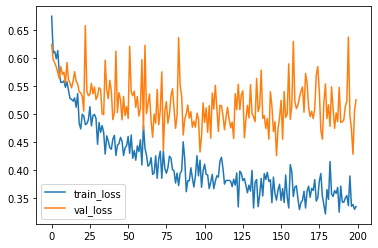

In [29]:
plt.plot(M.history['loss'],label = 'train_loss')
plt.plot(M.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()

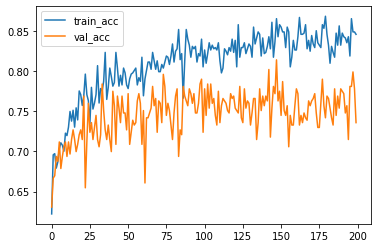

In [30]:
plt.plot(M.history['accuracy'],label = 'train_acc')
plt.plot(M.history['val_accuracy'],label = 'val_acc')
plt.legend()
plt.show()

In [31]:
pred = model.predict(A1)

In [32]:
pred = np.argmax(pred, axis=1)
pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0])

In [33]:
from sklearn.metrics import classification_report

In [34]:
res = pd.read_csv("../input/answers/answers.csv")

In [35]:
res.head()

,id,Predicted
0,test_0.png,0
1,test_1.png,0
2,test_2.png,0
3,test_3.png,0
4,test_4.png,0


In [38]:
c =0
for i in range(180):
    if res['Predicted'][i]==pred[i]:
        c = c+1
        
print(c)
print("accuracy : ",c/180)

146
accuracy :  0.8111111111111111


In [36]:
print(classification_report(res['Predicted'],pred))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86       114
           1       0.81      0.64      0.71        66

    accuracy                           0.81       180
   macro avg       0.81      0.77      0.79       180
weighted avg       0.81      0.81      0.81       180

